In [1]:
import numpy as np
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn
seaborn.set()

#Python files given with the notebook
import reservoir
import kuramoto
%load_ext autoreload
%autoreload 2
#Chose here if you want to use the GPU for  handling the tensors 
#/!\ This not for chosing whether you perform the projection on the GPU or OPU, this will be in random_projection
cuda = True
if cuda ==True:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
else:
    device = torch.device("cpu")

## Kuramoto-Sivashinsky chaotic time-series prediction
Highly non-linear (derivatives of order 4) chaotic time-series (https://en.wikipedia.org/wiki/Kuramoto%E2%80%93Sivashinsky_equation). 

This is the hardest task for benchmarking chaotic-time series. 

Author: Ruben Ohana (PhD candidate at LightOn & Ecole Normale Supérieure of Paris - https://rubenohana.github.io/) 


In [2]:
#Selecting the parameters and creating the time-series
seed = 1 # fix the seed
L = 22 / (2 * np.pi)  # length scale (don't tune it)
N = 1000  # dimension of the time-series (can be tuned)
dt = 0.25   # time discretization step (don't tune it)
N_train = 7000 # Training set (number of time steps)
N_test = 4200 # Testing set (number of time steps)
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

np.random.seed(seed)
dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

Changing N changes the dimension of the time-series. If this becomes larger, the computations will become slower on GPU, but not on the OPU because its speed does not depend on the dimension of the time-series.

Generally, for high-dimensional time-series, we will need higher-dimensional reservoirs so the OPU will shine with quite high-dimensional time-series.

If the reservoir is too high-dimensional (around 20 000) for the training method which is 'cholesky' by default, you can use method='sgd' which will work in higher dimensions but will have more hyperparameters.

# Optical Reservoir Computing with the OPU

In [3]:
# OPU training
n_res = 12000 - input_dim # Number of neurons of the Reservoir: the OPU will shine with increasing n_res
input_scale = 0.5 * 1.5 #0.5 Aurora A# Important parameter to tweek (the standard deviation of the input random matrix W_in)
res_scale =  0.65 * 1.5 #0.65 Aurora A Important parameter to tweek (the standard deviation of the reservoir random matrix W_res)
bias_scale = 0.4 
renorm_factor = 1.1 * np.sqrt(input_dim / n_res)
alpha = 1e-2 # regularization parameter in the linear regression, can be tweeked but this value is ok
leak_rate = 1 # 1 - leaking rate (=1 is standard reservoir computing)

# iterating the reservoir on the training set
model_lopu = reservoir.ESN(input_dim, res_size=n_res, device = device, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=leak_rate, bias_scale = bias_scale, random_projection='opu', seed=seed, precision = 6)


In [4]:
X_lopu = model_lopu.forward(u_train_t).to(device)
#concatenante reservoir states with the training set for better prediction
X_lopu = torch.cat((X_lopu, u_train_t*renorm_factor), dim=1)


100%|██████████| 7000/7000 [17:41<00:00,  6.60it/s]


In [6]:
#Generation of train data (shift of 1 at each time step, not important)
out_train = torch.zeros(input_len, input_dim).to(device)
for pred_horizon in range(1, 2):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)
print("Training weights")
output_w_lopu = model_lopu.train(X_lopu, out_train, alpha = alpha).to(device)

print("Testing forward")
test_len = 4000
Xtest_lopu = model_lopu.forward(u_test_t[:test_len]).to(device)

Training weights
Testing forward


100%|██████████| 4000/4000 [10:04<00:00,  6.62it/s]


In [7]:
print("Testing recursive prediction")
n_rec = 199
rec_pred_data_lopu = model_lopu.rec_pred(Xtest_lopu, output_w_lopu, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)
print("Finished")

Testing recursive prediction


100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Finished


In [8]:
#new_pred_horizon = (n_rec+1)
#out_test = torch.zeros(N_test, input_dim * new_pred_horizon).to(device)
#for pred_horizon in range(1, new_pred_horizon+1):
#    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)
#print(out_test.shape)
#out_test = out_test[:test_len, :]

pred_plot_lopu = rec_pred_data_lopu[0, :].reshape((n_rec+1), input_dim).cpu()
true_plot = u_test_t[test_len:test_len+(n_rec+1),:].cpu() #out_test[0, :].reshape(-1, input_dim).cpu()

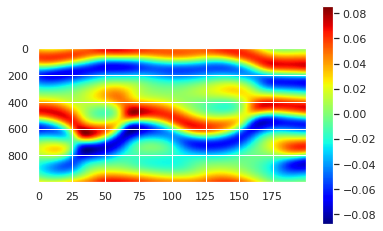

In [10]:
#What we want to predict
cmap = 'jet'
plt.imshow(true_plot.T,cmap=cmap, aspect = 0.1)
plt.colorbar();

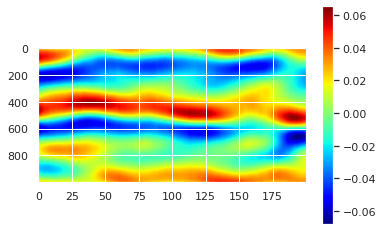

In [11]:
# The prediction

plt.imshow((pred_plot_lopu).T,cmap=cmap, aspect = 0.1)
plt.colorbar();

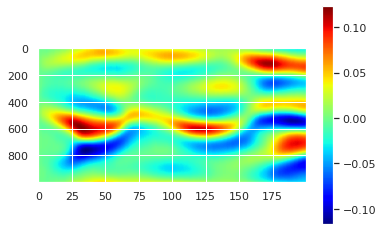

In [12]:
# Difference between truth and prediction
plt.imshow((true_plot - pred_plot_lopu).T,cmap=cmap, aspect = 0.1)
plt.colorbar();

### GPU

In [13]:
# GPU training

n_res = 12000 - input_dim # Number of neurons of the Reservoir
input_scale = 0.4# Important parameter to tweek (the standard deviation of the input random matrix W_in)
res_scale =  0.9 # Important parameter to tweek (the standard deviation of the reservoir random matrix W_res)
bias_scale = 0.4 
renorm_factor = 1.1 * np.sqrt(input_dim / n_res)
alpha = 1e-2 # regularization parameter in the linear regression, can be tweeked but this value is ok
leak_rate = 1 # 1 - leaking rate (=1 is standard reservoir computing)

# iterating the reservoir on the training set
model_gpu = reservoir.ESN(input_dim, res_size=n_res, device = device, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=leak_rate, bias_scale = bias_scale, random_projection='gpu', seed=seed)
X_gpu = model_gpu.forward(u_train_t).to(device)
#concatenante reservoir states with the training set for better prediction
X_gpu = torch.cat((X_gpu, u_train_t*renorm_factor), dim=1)


100%|██████████| 7000/7000 [00:13<00:00, 512.55it/s]


In [14]:
# Generation of train data
pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)
print("Training weights")
output_w_gpu = model_gpu.train(X_gpu, out_train, method = 'cholesky',lr = 0.01, alpha = alpha, epochs = 10000).to(device)

print("Testing forward")
test_len = 3001
Xtest_gpu = model_gpu.forward(u_test_t[:test_len]).to(device)



Training weights
Testing forward


100%|██████████| 3001/3001 [00:05<00:00, 520.81it/s]


In [15]:
import reservoir
#print("Testing recursive prediction")
n_rec =199
rec_pred_data_gpu = model_gpu.rec_pred(Xtest_gpu, output_w_gpu, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)

#print("Finished")

100%|██████████| 199/199 [00:00<00:00, 1906.97it/s]


In [16]:
#new_pred_horizon = pred_horizon_range * (n_rec+1)
#out_test = torch.zeros(N_test, input_dim * new_pred_horizon).to(device)
#for pred_horizon in range(1, new_pred_horizon+1):
#    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)
#out_test = out_test[:test_len, :]

pred_plot_gpu = rec_pred_data_gpu[0, :].reshape((n_rec+1)*pred_horizon_range, input_dim).cpu()
true_plot = u_test_t[test_len:test_len+(n_rec+1),:].cpu()#out_test[0, :].reshape(-1, input_dim).cpu()

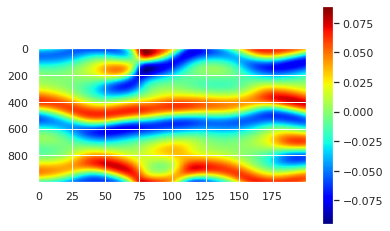

In [17]:
# What we want to predict
cmap = 'jet'
plt.imshow(true_plot.T,cmap=cmap, aspect = 0.1)
plt.colorbar();

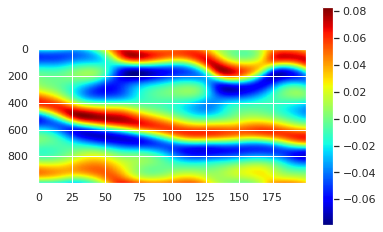

In [18]:
# The prediction
plt.imshow(pred_plot_gpu.T,cmap=cmap, aspect = 0.1)
plt.colorbar();

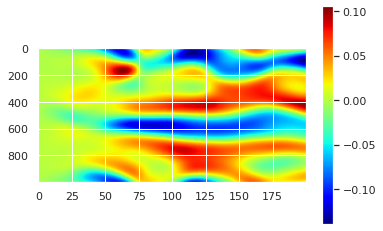

In [20]:
# The difference between the two
plt.imshow((true_plot - pred_plot_gpu).T,cmap=cmap, aspect = 0.1)
plt.colorbar();